### Load Data and Threshold Masks

### Unpack Images and Segmentation Masks

The `unpackage_inputs` is a utility function that is used to unpack the inputs from the
dictionary format to a tuple of `(images, segmentation_masks)`. This will be used later
on for visualizing the images and segmentation masks and also the model predictions.

## Ground Truth Visualizations

Let's visualized a few images and their segmentation masks from the training data, with
the `keras_cv.visualization.plot_segmentation_mask_gallery` API.

Intersection over Union (IoU) is a metric often used in segmentation problems to assess the model's accuracy. It provides a more intuitive basis for accuracy that is not biased by the (unbalanced) percentage of pixels from any particular class. Given two segmentation masks, `A` and `B`, the IoU is defined as follows:

$$ 
IoU = \frac{|A\cap B\hspace{1mm}|}{|A\cup B\hspace{1mm}|} \hspace{2mm}
$$

When there are multiple classes and inferences, we assess the model's performance by computing the mean IoU.

The function below computes the mean IoU that only considers the classes that are present in the ground truth mask or the predicted segmentation map (sometimes referred to as classwise mean IoU). This computation is a better representation of the metric since it only considers the relevant classes. **This is the metric computation we use for mean IoU.**

### Tensorboard and ModelCheckpoint Callbacks

## Train the model

Now let's create the model, compile and train by calling `model.fit()` using the configurations defined in the `Trainingconfig` class.

In [7]:
# Install necessary package
!pip install -q git+https://github.com/keras-team/keras-cv.git --upgrade

# Import necessary libraries
import os
import requests
from zipfile import ZipFile
import glob
from dataclasses import dataclass

import random
import numpy as np
import cv2

import tensorflow as tf
import keras_cv

import matplotlib.pyplot as plt

In [8]:
# System configuration function
def system_config(SEED_VALUE):
    random.seed(SEED_VALUE)
    tf.keras.utils.set_random_seed(SEED_VALUE)
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'     
    os.environ['TF_USE_CUDNN'] = "true"

system_config(SEED_VALUE=42)


In [9]:
# Download and unzip function
def download_and_unzip(url, save_path):
    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)
    try:
        if save_path.endswith(".zip"):
            with ZipFile(save_path) as zip:
                zip.extractall(os.path.split(save_path)[0])
        print("Done")
    except:
        print("Invalid file")


In [10]:

# Download dataset if it does not exist

DATASET_URL = r"https://www.dropbox.com/scl/fi/9k8t9619b4x0hegued5c5/Water-Bodies-Dataset.zip?rlkey=tjgepcai6t74yynmx7tqsm7af&dl=1"
DATASET_DIR = "Water-Bodies-Dataset"
DATASET_ZIP_PATH = os.path.join(os.getcwd(), f"{DATASET_DIR}.zip")
if not os.path.exists(DATASET_DIR):
    download_and_unzip(DATASET_URL, DATASET_ZIP_PATH)
    os.remove(DATASET_ZIP_PATH)

In [11]:
# Dataset configuration
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE: tuple = (256, 256)
    BATCH_SIZE: int = 8
    NUM_CLASSES: int = 2
    BRIGHTNESS_FACTOR: float = 0.2
    CONTRAST_FACTOR: float = 0.2

In [12]:
@dataclass(frozen=True)
class TrainingConfig:
    MODEL: str = "mobilenet_v3_large_imagenet"
    EPOCHS: int = 45
    FINE_TUNE_EPOCHS: int = 15
    LEARNING_RATE: float = 1e-4
    FINE_TUNE_LEARNING_RATE: float = 1e-5  
    CKPT_DIR: str = os.path.join("checkpoints", "deeplabv3_plus_" + "_".join(MODEL.split("_")[:2]) + ".weights.h5")
    LOGS_DIR: str = "logs_" + "_".join(MODEL.split("_")[:2])
    

train_config = TrainingConfig()
data_config = DatasetConfig()

In [13]:

data_images = glob.glob(os.path.join(DATASET_DIR, "Images", "*.jpg"))
data_masks = glob.glob(os.path.join(DATASET_DIR, "Masks", "*.jpg"))


In [14]:
import os
import glob
import tensorflow as tf
import os
from PIL import Image


# Function to load dataset with supported image file formats
def load_dataset(images_dir, masks_dir, img_extensions=("*.jpg"), mask_extensions=("*.jpg")):
    images = []
    masks = []
    for ext in img_extensions:
        image_files = glob.glob(os.path.join(images_dir, ext))
        image_files = [f for f in image_files if not f.endswith('.DS_Store')]
        images.extend(image_files)
    for ext in mask_extensions:
        masks_files = glob.glob(os.path.join(masks_dir, ext))
        masks_files = [f for f in masks_files if not f.endswith('.DS_Store')]
        masks.extend(masks_files)
    return sorted(images), sorted(masks)



# Additional dataset directories
additional_images_dir = "/kaggle/input/flood-w/archive/Image"
additional_masks_dir = "/kaggle/input/flood-w/archive/Mask"

# Load existing dataset
existing_data_images = data_images
existing_data_masks = data_masks 

# Load additional dataset
# additional_data_images, additional_data_masks = load_dataset(additional_images_dir, additional_masks_dir)

# Merge datasets
#data_images = existing_data_images + additional_data_images
#data_masks = existing_data_masks + additional_data_masks

# Ensure the number of images and masks match
assert len(data_images) == len(data_masks), "Number of images and masks do not match!"

# Print summary
print(f"Total images: {len(data_images)}")
print(f"Total masks: {len(data_masks)}")


Total images: 2841
Total masks: 2841


In [15]:
# Shuffle and split dataset
zipped_data = list(zip(data_images, data_masks))
random.shuffle(zipped_data)
data_images, data_masks = zip(*zipped_data)
data_images = list(data_images)
data_masks = list(data_masks)

org_data = tf.data.Dataset.from_tensor_slices((data_images, data_masks))
SPLIT_RATIO = 0.1
NUM_VAL = int(len(data_images) * SPLIT_RATIO)
train_data = org_data.skip(2 * NUM_VAL)
valid_data = org_data.skip(NUM_VAL).take(NUM_VAL)
test_data = org_data.take(NUM_VAL)

In [16]:
# Functions to read and process images and masks
def read_image_mask(image_path, mask=False, size=data_config.IMAGE_SIZE):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_jpeg(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=size, method="bicubic")
        image_mask = tf.zeros_like(image)
        cond = image >= 200
        updates = tf.ones_like(image[cond])
        image_mask = tf.tensor_scatter_nd_update(image_mask, tf.where(cond), updates)
        image = tf.cast(image_mask, tf.uint8)
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=size, method="bicubic")
        image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)
    return image

def load_data(image_list, mask_list):
    image = read_image_mask(image_list)
    mask = read_image_mask(mask_list, mask=True)
    return {"images": image, "segmentation_masks": mask}

In [17]:




# Create datasets
train_ds = train_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
# Function to unpack inputs
def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks


In [19]:
# Dictionary mapping class IDs to colors
id2color = {
    0: (0, 0, 0),        # Background
    1: (102, 204, 255),  # Waterbody
}

In [20]:

# Functions for image and mask visualization
def num_to_rgb(num_arr, color_map=id2color):
    output = np.zeros(num_arr.shape[:2] + (3,))
    for k in color_map.keys():
        output[num_arr == k] = color_map[k]
    return output.astype(np.uint8)

def image_overlay(image, segmented_image):
    alpha = 1.0
    beta = 0.7
    gamma = 0.0
    image = image.astype(np.uint8)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask
    if len(data_list) == 3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask
    overlayed_image = image_overlay(data_list[0], mask_to_overlay)
    data_list.append(overlayed_image)
    title_list.append("Overlayed Image")  # Add the title for the overlayed image
    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)
    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])
        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")
        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")
        else:
            axis.imshow(data_list[idx])
        axis.axis('off')
    plt.show()

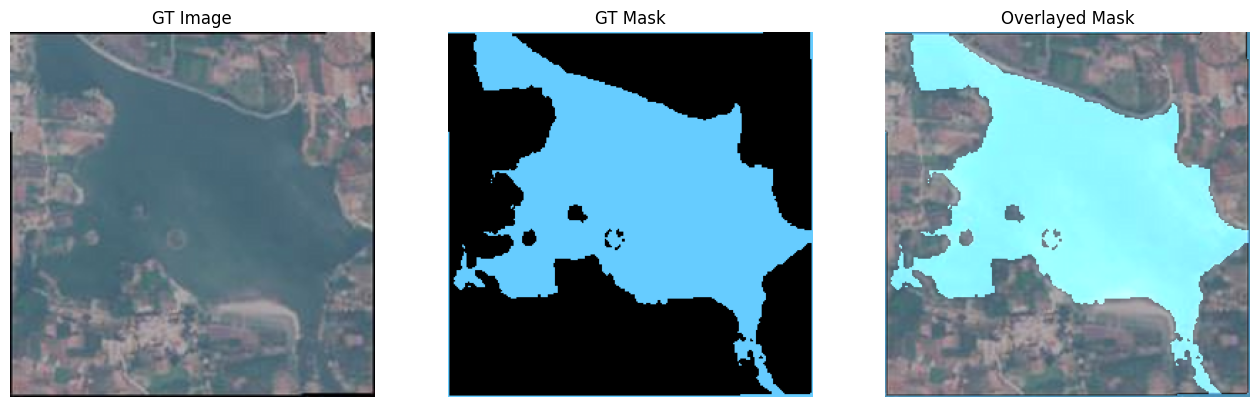

In [21]:
# Visualize dataset
plot_train_ds = train_ds.map(unpackage_inputs).batch(1)
image_batch, mask_batch = next(iter(plot_train_ds.take(1)))
titles = ["GT Image", "GT Mask", "Overlayed Mask"]
for image, gt_mask in zip(image_batch, mask_batch):
    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask], title_list=titles, figsize=(16, 6), color_mask=True)


In [22]:
# Data augmentation
augment_fn = tf.keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomBrightness(factor=data_config.BRIGHTNESS_FACTOR, value_range=(0, 255)),
        keras_cv.layers.RandomContrast(factor=data_config.CONTRAST_FACTOR, value_range=(0, 255)),
    ]
)
train_dataset = (
    train_ds.shuffle(data_config.BATCH_SIZE)
    .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(data_config.BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
valid_dataset = (
    valid_ds.batch(data_config.BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
test_dataset = (
    test_ds.batch(data_config.BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

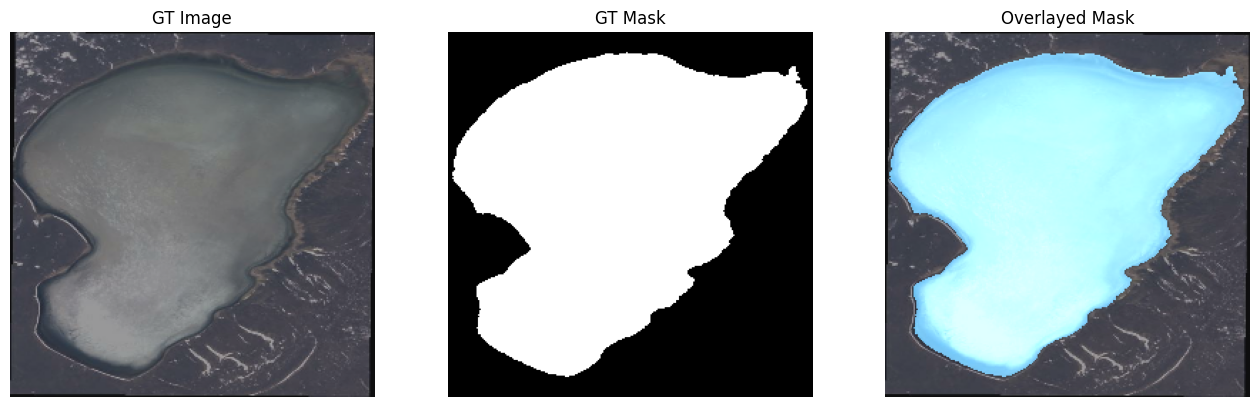

In [23]:
# Visualize augmented dataset
image_batch, aug_mask_batch = next(iter(train_dataset.take(3)))
for idx, (image, gt_mask) in enumerate(zip(image_batch, aug_mask_batch)):
    if idx == 1:
        break
    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask], title_list=titles, figsize=(16, 6), color_mask=False)


In [24]:
# Load backbone and build model
backbone = keras_cv.models.MobileNetV3Backbone.from_preset(
    preset=train_config.MODEL,
    
    input_shape=data_config.IMAGE_SIZE + (3,),
    load_weights=True
)
model1 = keras_cv.models.segmentation.DeepLabV3Plus(num_classes=data_config.NUM_CLASSES, backbone=backbone)
# print(model.summary())


Attaching 'config.json' from model 'keras/mobilenetv3/keras/mobilenet_v3_large_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/mobilenetv3/keras/mobilenet_v3_large_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/mobilenetv3/keras/mobilenet_v3_large_imagenet/2' to your Kaggle notebook...


In [25]:
# Load backbone and build model
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    preset="efficientnetv2_s_imagenet",
    
    input_shape=data_config.IMAGE_SIZE + (3,),
    load_weights=True
)
model2 = keras_cv.models.segmentation.DeepLabV3Plus(num_classes=data_config.NUM_CLASSES, backbone=backbone)
# print(model.summary())


Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_s_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_s_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_s_imagenet/2' to your Kaggle notebook...


In [26]:
# Load backbone and build model
backbone = keras_cv.models.ResNet50V2Backbone.from_preset(
    preset="resnet50_v2_imagenet",
    
    input_shape=data_config.IMAGE_SIZE + (3,),
    load_weights=True
)
model3 = keras_cv.models.segmentation.DeepLabV3Plus(num_classes=data_config.NUM_CLASSES, backbone=backbone)
# print(model.summary())


Attaching 'config.json' from model 'keras/resnetv2/keras/resnet50_v2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/resnetv2/keras/resnet50_v2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/resnetv2/keras/resnet50_v2_imagenet/2' to your Kaggle notebook...


In [27]:
input_shape=data_config.IMAGE_SIZE + (3,),

In [28]:
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.models import Model

In [29]:
input_shape = (256, 256, 3)

In [30]:
# Define Weights for Each Model
weights = [0.3, 0.2, 0.5]  # Example weights for the three models

# Function to Create Weighted Averaging Ensemble
def ensemble_models(models, weights, input_shape):
    inputs = Input(shape=input_shape)
    outputs = [model(inputs) for model in models]

    # Apply weights to each model's output
    weighted_outputs = [Lambda(lambda x: x * weight)(output) for output, weight in zip(outputs, weights)]
    
    # Sum the weighted outputs
    avg_output = Add()(weighted_outputs)
    
    ensemble_model = Model(inputs, avg_output)
    return ensemble_model

# Create the ensemble model with weighted averaging
ensemble_model = ensemble_models([model1, model2, model3], weights, input_shape)




# def ensemble_models(models, input_shape):
#     inputs = Input(shape=input_shape)
#     outputs = [model(inputs) for model in models]
#     avg_output = Average()(outputs)
#     ensemble_model = Model(inputs, avg_output)
#     return ensemble_model

# ensemble_model = ensemble_models([model1, model2, model3], input_shape)


In [31]:
# Callbacks

def get_callbacks(train_config, monitor="val_mean_iou", mode="max", save_weights_only=True, save_best_only=True, patience=5):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=train_config.LOGS_DIR,
        histogram_freq=20,
        write_graph=False,
        update_freq="epoch",  # Set update_freq to 'epoch'
    )
    checkpoint_filepath = train_config.CKPT_DIR
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=1,
        # patience=patience  # Add patience parameter
    )
    return [tensorboard_callback, model_checkpoint_callback]



In [32]:
# Mean IOU metric
def mean_iou(y_true, y_pred):
    num_classes = y_pred.shape[-1]
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=(1, 2))
    total = tf.math.reduce_sum(y_true, axis=(1, 2)) + tf.math.reduce_sum(y_pred, axis=(1, 2))
    union = total - intersection
    is_class_present = tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)
    iou = tf.math.divide_no_nan(intersection, union)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present
    mean_iou = tf.math.reduce_mean(iou)
    return mean_iou

# Define precision, recall, f1_score, and mse functions
def precision(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    possible_positives = tf.reduce_sum(y_true)
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + tf.keras.backend.epsilon())

def mse(y_true, y_pred):
    return tf.keras.losses.MeanSquaredError()(y_true, y_pred)

In [33]:
# Build model
callbacks = get_callbacks(train_config)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


ensemble_model.compile(
    optimizer=tf.keras.optimizers.Adam(train_config.LEARNING_RATE),
    loss=loss_fn,
    metrics=["accuracy", mean_iou, precision, recall, f1_score, mse],
)

In [34]:
# Training the model
history = ensemble_model.fit(
    train_dataset,
    epochs=train_config.EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/45


2024-06-25 03:24:40.615766: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_31_1/deep_lab_v3_plus_1_2/functional_11_1/block1b__1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.8095 - f1_score: 0.6890 - loss: 0.4177 - mean_iou: 0.5936 - mse: 0.3545 - precision: 0.7380 - recall: 0.6684
Epoch 1: val_mean_iou improved from -inf to 0.72194, saving model to checkpoints/deeplabv3_plus_mobilenet_v3.weights.h5
285/285 ━━━━━━━━━━━━━━━━━━━━ 404s 837ms/step - accuracy: 0.8097 - f1_score: 0.6891 - loss: 0.4175 - mean_iou: 0.5938 - mse: 0.3546 - precision: 0.7383 - recall: 0.6684 - val_accuracy: 0.8904 - val_f1_score: 0.8042 - val_loss: 0.3119 - val_mean_iou: 0.7219 - val_mse: 0.3649 - val_precision: 0.8438 - val_recall: 0.7838
Epoch 2/45
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.8859 - f1_score: 0.8024 - loss: 0.2813 - mean_iou: 0.7156 - mse: 0.4023 - precision: 0.8608 - recall: 0.7615
Epoch 2: val_mean_iou did not improve from 0.72194
285/285 ━━━━━━━━━━━━━━━━━━━━ 204s 717ms/step - accuracy: 0.8859 - f1_score: 0.8024 - loss: 0.2813 - mean_iou: 0.7157 - mse: 0.4023 - precision: 0.8608 - recall: 0.7616

In [35]:
def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision


def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + tf.keras.backend.epsilon())

def mse(y_true, y_pred):
    return tf.keras.losses.MeanSquaredError()(y_true, y_pred)

# Add these custom metrics to the model compilation
ensemble_model.compile(
    optimizer=tf.keras.optimizers.Adam(train_config.LEARNING_RATE),
    loss=loss_fn,
    metrics=["accuracy", mean_iou, precision, recall, f1_score, mse],
)





In [36]:
# Define a function to plot the metrics

def plot_metrics(history, metric_name, title):
    plt.figure(figsize=(9, 4))
    plt.plot(history.history[metric_name])
    plt.plot(history.history[f'val_{metric_name}'])
    plt.title(f'Model {title}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.capitalize())
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)
    plt.show()

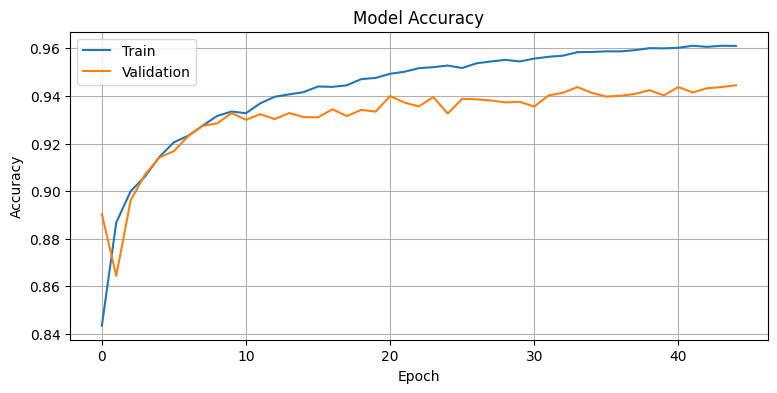

<Figure size 640x480 with 0 Axes>

In [37]:
# Plot accuracy
plot_metrics(history, 'accuracy', 'Accuracy')
plt.savefig("Accuracy.png")



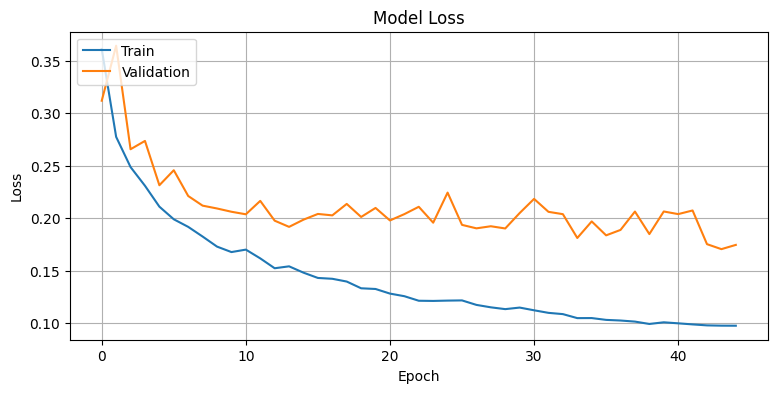

<Figure size 640x480 with 0 Axes>

In [38]:
plot_metrics(history, 'loss', 'Loss')
plt.savefig("loss.png")

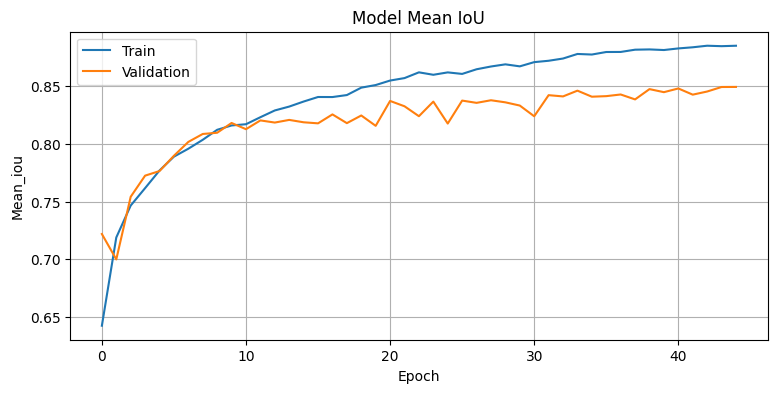

<Figure size 640x480 with 0 Axes>

In [39]:
# Plot mean IoU
plot_metrics(history, 'mean_iou', 'Mean IoU')
plt.savefig("mean IoU.png")



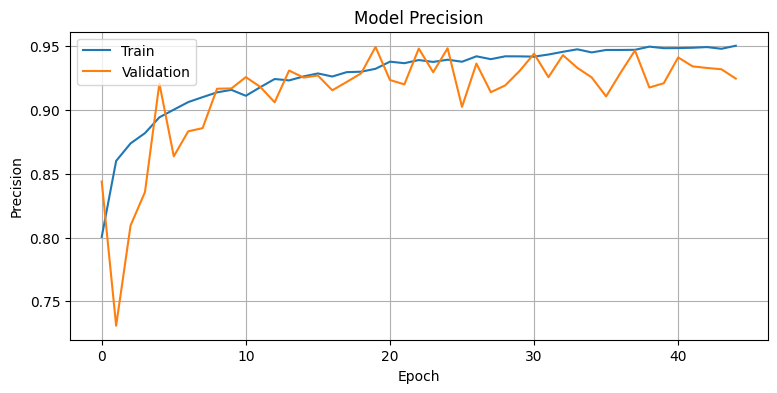

<Figure size 640x480 with 0 Axes>

In [40]:
# Plot precision
plot_metrics(history, 'precision', 'Precision')
plt.savefig("Precision.png")


In [59]:
# # Plot recall
# plot_metrics(history, 'recall', 'Recall')
# plt.savefig("recall.png")


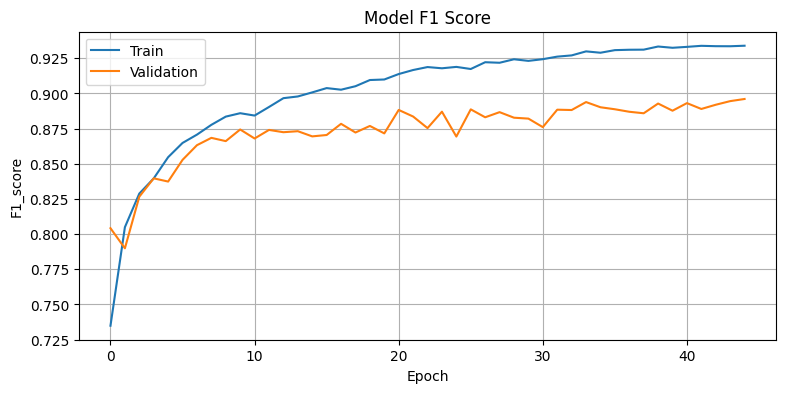

<Figure size 640x480 with 0 Axes>

In [42]:

# Plot F1 score
plot_metrics(history, 'f1_score', 'F1 Score')
plt.savefig("F-1 Score.png")



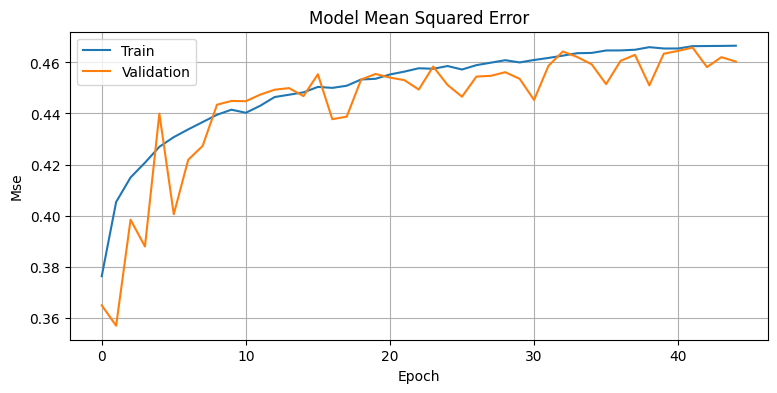

<Figure size 640x480 with 0 Axes>

In [43]:
# Plot MSE
plot_metrics(history, 'mse', 'Mean Squared Error')
plt.savefig("MSE.png")

#### Load Fine-tuned Model Weights

In [44]:
print(len(test_ds))
print(len(train_ds))
print(len(valid_ds))
dataset_size=len(test_ds)+len(train_ds)+len(valid_ds)
print(f'\nTotal size of dataset : {dataset_size}')

284
2273
284

Total size of dataset : 2841


In [45]:
import tensorflow as tf
import numpy as np

# Combine training and validation datasets into a single evaluation dataset
eval_ds = train_ds.concatenate(valid_ds).batch(data_config.BATCH_SIZE)

# Initialize accumulators for metrics
total_accuracy = 0.0
total_precision = 0.0
total_recall = 0.0
total_mse = 0.0
total_loss = 0.0
total_f1 = 0.0
total_iou = 0.0
total_samples = 0

# Define precision, recall, and F1 score functions
def precision(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    possible_positives = tf.reduce_sum(y_true)
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + tf.keras.backend.epsilon())

# IoU calculation function
def iou(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.cast(tf.math.logical_or(tf.cast(y_true, tf.bool), tf.cast(y_pred, tf.bool)), tf.float32))
    iou = (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())
    return iou

# Evaluation loop
for batch in eval_ds:
    imgs, masks = batch['images'], batch['segmentation_masks']
    total_samples += imgs.shape[0]

    # Make predictions
    prediction = ensemble_model(imgs, training=False)
    pred_masks = tf.argmax(prediction, axis=-1)
    pred_masks = tf.expand_dims(pred_masks, axis=-1)

    # Calculate loss
    loss = loss_fn(masks, prediction)

    # Calculate metrics
    total_loss += loss.numpy() * imgs.shape[0]
    total_accuracy += tf.keras.metrics.SparseCategoricalAccuracy()(masks, prediction).numpy() * imgs.shape[0]
    total_precision += precision(masks, prediction).numpy() * imgs.shape[0]
    total_recall += recall(masks, prediction).numpy() * imgs.shape[0]
    total_mse += tf.keras.losses.MeanSquaredError()(tf.cast(masks, tf.float32), tf.cast(pred_masks, tf.float32)).numpy() * imgs.shape[0]
    total_f1 += f1_score(masks, prediction).numpy() * imgs.shape[0]
    total_iou += iou(masks, prediction).numpy() * imgs.shape[0]

# Compute overall metrics
overall_accuracy = total_accuracy / total_samples
overall_precision = total_precision / total_samples
overall_recall = total_recall / total_samples
overall_mse = total_mse / total_samples
overall_loss = total_loss / total_samples
overall_f1 = total_f1 / total_samples
overall_iou = total_iou / total_samples

print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall MSE: {overall_mse}")
print(f"Overall Loss: {overall_loss}")
print(f"Overall F1 Score: {overall_f1}")
print(f"Overall IoU: {overall_iou}")


Overall Accuracy: 0.9608298589766469
Overall Precision: 0.9419392116329938
Overall Recall: 0.928078206363114
Overall MSE: 0.03917014099421518
Overall Loss: 0.10243231214883042
Overall F1 Score: 0.9343864598053249
Overall IoU: 0.8789682820829787


In [46]:

import tensorflow as tf
import numpy as np

# Combine training and validation datasets into a single evaluation dataset
eval_ds = test_ds.batch(data_config.BATCH_SIZE)

# Initialize accumulators for metrics
total_accuracy = 0.0
total_precision = 0.0
total_recall = 0.0
total_mse = 0.0
total_loss = 0.0
total_f1 = 0.0
total_iou = 0.0
total_samples = 0

# Define precision, recall, and F1 score functions
def precision(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    possible_positives = tf.reduce_sum(y_true)
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + tf.keras.backend.epsilon())

# IoU calculation function
def iou(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.cast(tf.math.logical_or(tf.cast(y_true, tf.bool), tf.cast(y_pred, tf.bool)), tf.float32))
    iou = (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())
    return iou

# Evaluation loop
for batch in eval_ds:
    imgs, masks = batch['images'], batch['segmentation_masks']
    total_samples += imgs.shape[0]

    # Make predictions
    prediction = ensemble_model(imgs, training=False)
    pred_masks = tf.argmax(prediction, axis=-1)
    pred_masks = tf.expand_dims(pred_masks, axis=-1)

    # Calculate loss
    loss = loss_fn(masks, prediction)

    # Calculate metrics
    total_loss += loss.numpy() * imgs.shape[0]
    total_accuracy += tf.keras.metrics.SparseCategoricalAccuracy()(masks, prediction).numpy() * imgs.shape[0]
    total_precision += precision(masks, prediction).numpy() * imgs.shape[0]
    total_recall += recall(masks, prediction).numpy() * imgs.shape[0]
    total_mse += tf.keras.losses.MeanSquaredError()(tf.cast(masks, tf.float32), tf.cast(pred_masks, tf.float32)).numpy() * imgs.shape[0]
    total_f1 += f1_score(masks, prediction).numpy() * imgs.shape[0]
    total_iou += iou(masks, prediction).numpy() * imgs.shape[0]

# Compute overall metrics
overall_accuracy = total_accuracy / total_samples
overall_precision = total_precision / total_samples
overall_recall = total_recall / total_samples
overall_mse = total_mse / total_samples
overall_loss = total_loss / total_samples
overall_f1 = total_f1 / total_samples
overall_iou = total_iou / total_samples

print(f"Overall Accuracy on test: {overall_accuracy}")
print(f"Overall Precision on test: {overall_precision}")
print(f"Overall Recall on test: {overall_recall}")
print(f"Overall MSE on test: {overall_mse}")
print(f"Overall Loss on test: {overall_loss}")
print(f"Overall F1 Score on test: {overall_f1}")
print(f"Overall IoU on test: {overall_iou}")


Overall Accuracy on test: 0.93556401427363
Overall Precision on test: 0.9010932252440654
Overall Recall on test: 0.886255144233435
Overall MSE on test: 0.06443598572636994
Overall Loss on test: 0.19230276178306258
Overall F1 Score on test: 0.8919466095910945
Overall IoU on test: 0.8104761922863167


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


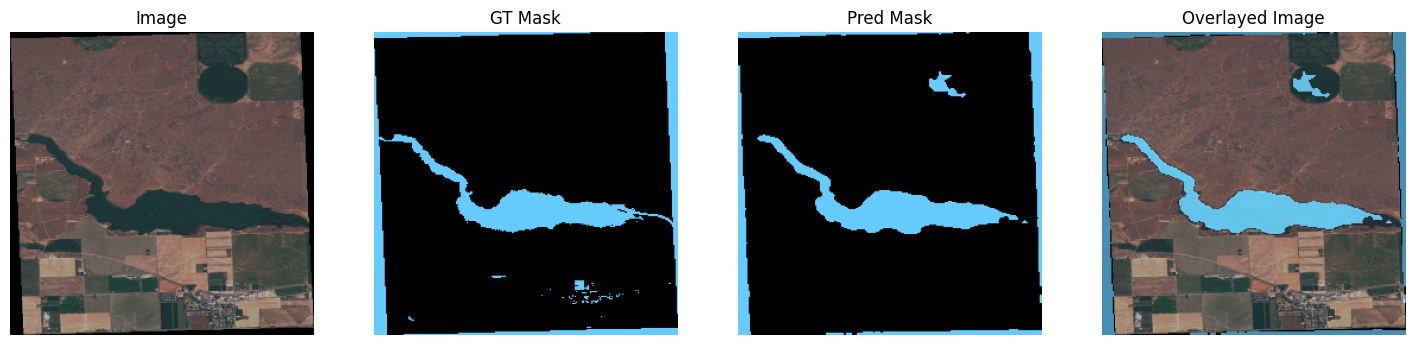

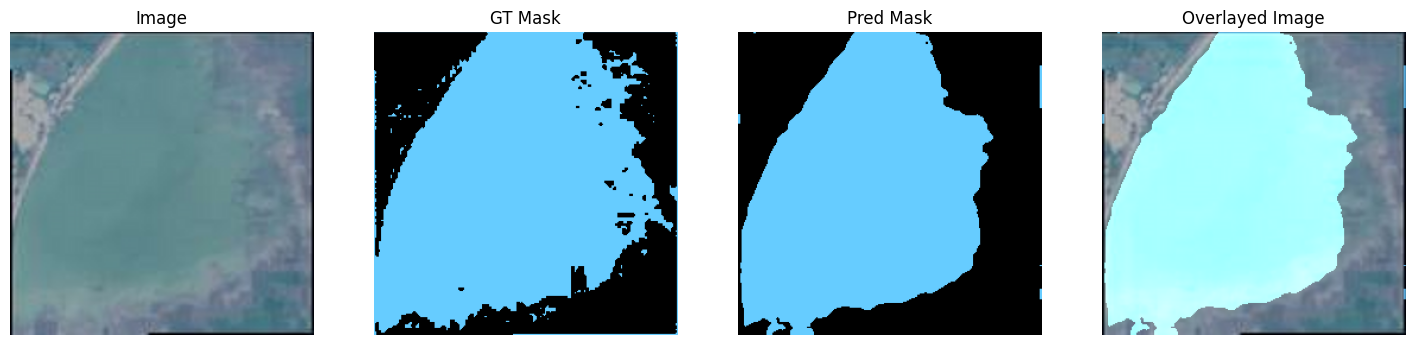

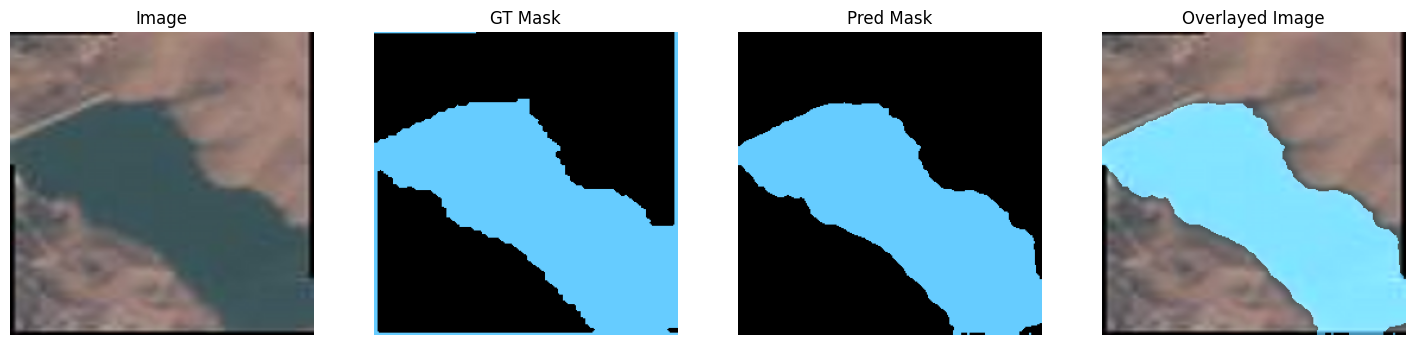

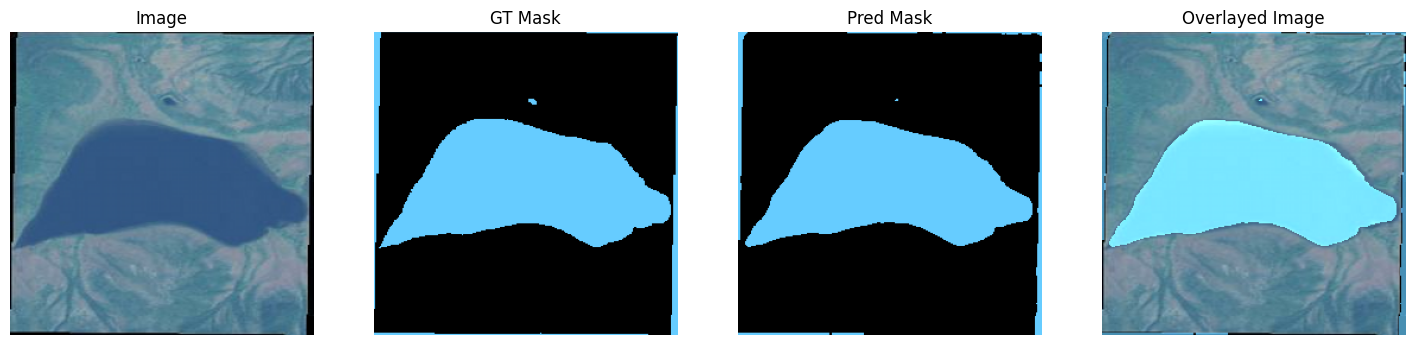

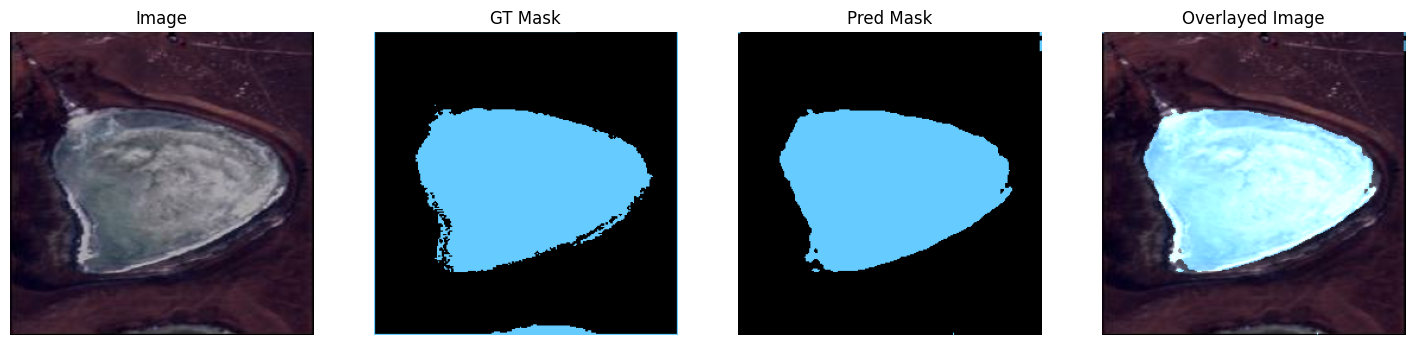

In [47]:
# Evaluate the model on the test dataset
# test_results = model.evaluate(test_dataset)

# print(f"Test Results - Loss: {test_results[0]} - Accuracy: {test_results[1]} - Mean IOU: {test_results[2]}")

# Function to predict and display results on test dataset
def predict_and_display(ensemble_model, test_dataset, num_images=5):
    for image_batch, mask_batch in test_dataset.take(1):
        pred_mask_batch = ensemble_model.predict(image_batch)
        for i in range(num_images):
            image = image_batch[i].numpy().astype(np.uint8)
            gt_mask = tf.squeeze(mask_batch[i], axis=-1).numpy()
            pred_mask = tf.argmax(pred_mask_batch[i], axis=-1).numpy()
            display_image_and_mask([image, gt_mask, pred_mask], title_list=["Image", "GT Mask", "Pred Mask"], figsize=(18, 6), color_mask=True)

# Predict and display results on the test dataset
predict_and_display(ensemble_model, test_dataset)


In [48]:
ensemble_model.load_weights(train_config.CKPT_DIR)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1726 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


#### Perform Evaluation

In [49]:
print(len(valid_dataset))
print(len(train_dataset))
print(len(test_dataset))

36
285
36


In [50]:
evaluate = ensemble_model.evaluate(valid_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - accuracy: 0.9439 - f1_score: 0.9015 - loss: 0.1618 - mean_iou: 0.8504 - mse: 0.4589 - precision: 0.3105 - recall: 1.0000


In [51]:
evaluate = ensemble_model.evaluate(test_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 307ms/step - accuracy: 0.9378 - f1_score: 0.8981 - loss: 0.1795 - mean_iou: 0.8434 - mse: 0.4597 - precision: 0.3296 - recall: 1.0000


## Prediction with Fine-tuned Model

Now that the model training of DeepLabv3 has been completed, let's test it by making predictions on a few sample images.

In [52]:
def inference(model, dataset, samples_to_plot):

    num_batches_to_process = 2
    count = 0
    stop_plot = False

    titles = ["Image", "GT Mask", "Pred Mask", "Overlayed Prediction"]

    for idx, data in enumerate(dataset):

        if stop_plot:
            break

        batch_img, batch_mask = data[0], data[1]
        batch_pred = (model.predict(batch_img)).astype('float32')
        batch_pred = batch_pred.argmax(axis=-1)
        
        batch_img  = batch_img.numpy().astype('uint8')
        batch_mask = batch_mask.numpy().squeeze(axis=-1)

        for image, mask, pred in zip(batch_img, batch_mask, batch_pred):
            count+=1
            display_image_and_mask([image, mask, pred],
                                  title_list=titles,
                                   figsize=(20,8),
                                   color_mask=True)
            if count >= samples_to_plot:
                stop_plot=True
                break
            

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


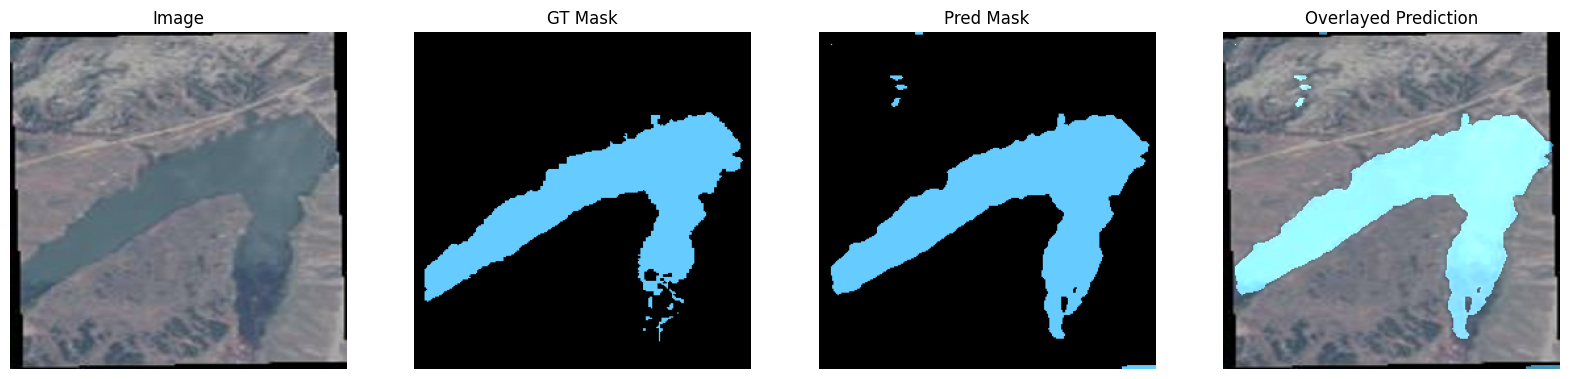

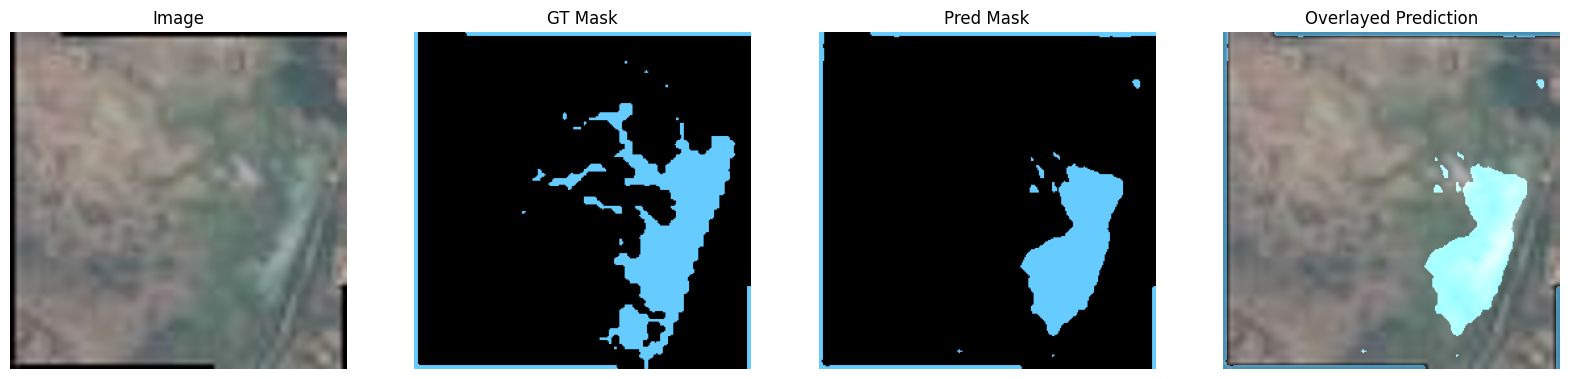

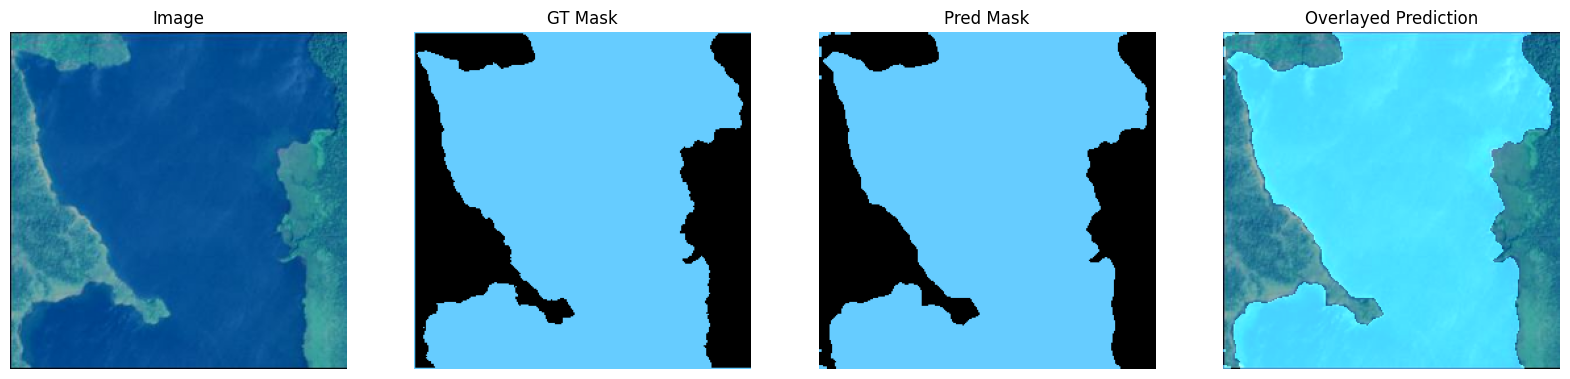

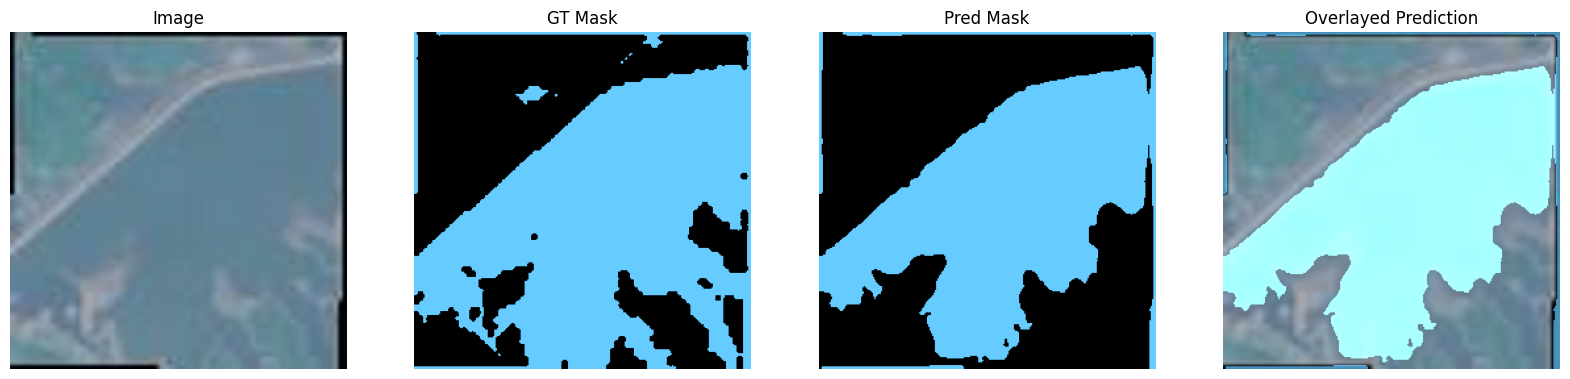

In [53]:
inference(ensemble_model, valid_dataset, samples_to_plot=4)

In [54]:

# Fine-tuning
print("Fine-tuning the model...")
backbone.trainable = True
for layer in ensemble_model.layers:
    if isinstance(layer, keras_cv.models.ResNet50V2Backbone):
        layer.trainable = True
    if isinstance(layer, keras_cv.models.EfficientNetV2Backbone):
        layer.trainable = True
    if isinstance(layer, keras_cv.models.MobileNetV3Backbone):
        layer.trainable = True

fine_tune_callbacks = get_callbacks(train_config, monitor="val_loss", mode="min")

ensemble_model.compile(
    optimizer=tf.keras.optimizers.Adam(train_config.FINE_TUNE_LEARNING_RATE),
    loss=loss_fn,
    metrics=["accuracy", mean_iou, precision, recall, f1_score, mse],
)

fine_tune_history = ensemble_model.fit(
    train_dataset,
    epochs=train_config.FINE_TUNE_EPOCHS,
    validation_data=valid_dataset,
    callbacks=fine_tune_callbacks
)

Fine-tuning the model...
Epoch 1/15


2024-06-25 06:10:17.972922: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_31_1/deep_lab_v3_plus_1_2/functional_11_1/block1b__1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9623 - f1_score: 0.9362 - loss: 0.0933 - mean_iou: 0.8857 - mse: 0.4679 - precision: 0.9511 - recall: 0.9224
Epoch 1: val_loss improved from inf to 0.17895, saving model to checkpoints/deeplabv3_plus_mobilenet_v3.weights.h5
285/285 ━━━━━━━━━━━━━━━━━━━━ 390s 820ms/step - accuracy: 0.9623 - f1_score: 0.9362 - loss: 0.0933 - mean_iou: 0.8858 - mse: 0.4679 - precision: 0.9511 - recall: 0.9224 - val_accuracy: 0.9453 - val_f1_score: 0.8966 - val_loss: 0.1790 - val_mean_iou: 0.8534 - val_mse: 0.4671 - val_precision: 0.9309 - val_recall: 0.8739
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.9633 - f1_score: 0.9379 - loss: 0.0900 - mean_iou: 0.8896 - mse: 0.4692 - precision: 0.9496 - recall: 0.9273
Epoch 2: val_loss improved from 0.17895 to 0.17797, saving model to checkpoints/deeplabv3_plus_mobilenet_v3.weights.h5
285/285 ━━━━━━━━━━━━━━━━━━━━ 208s 731ms/step - accuracy: 0.9633 - f1_score: 0.9379 - loss: 0.0900 - mean

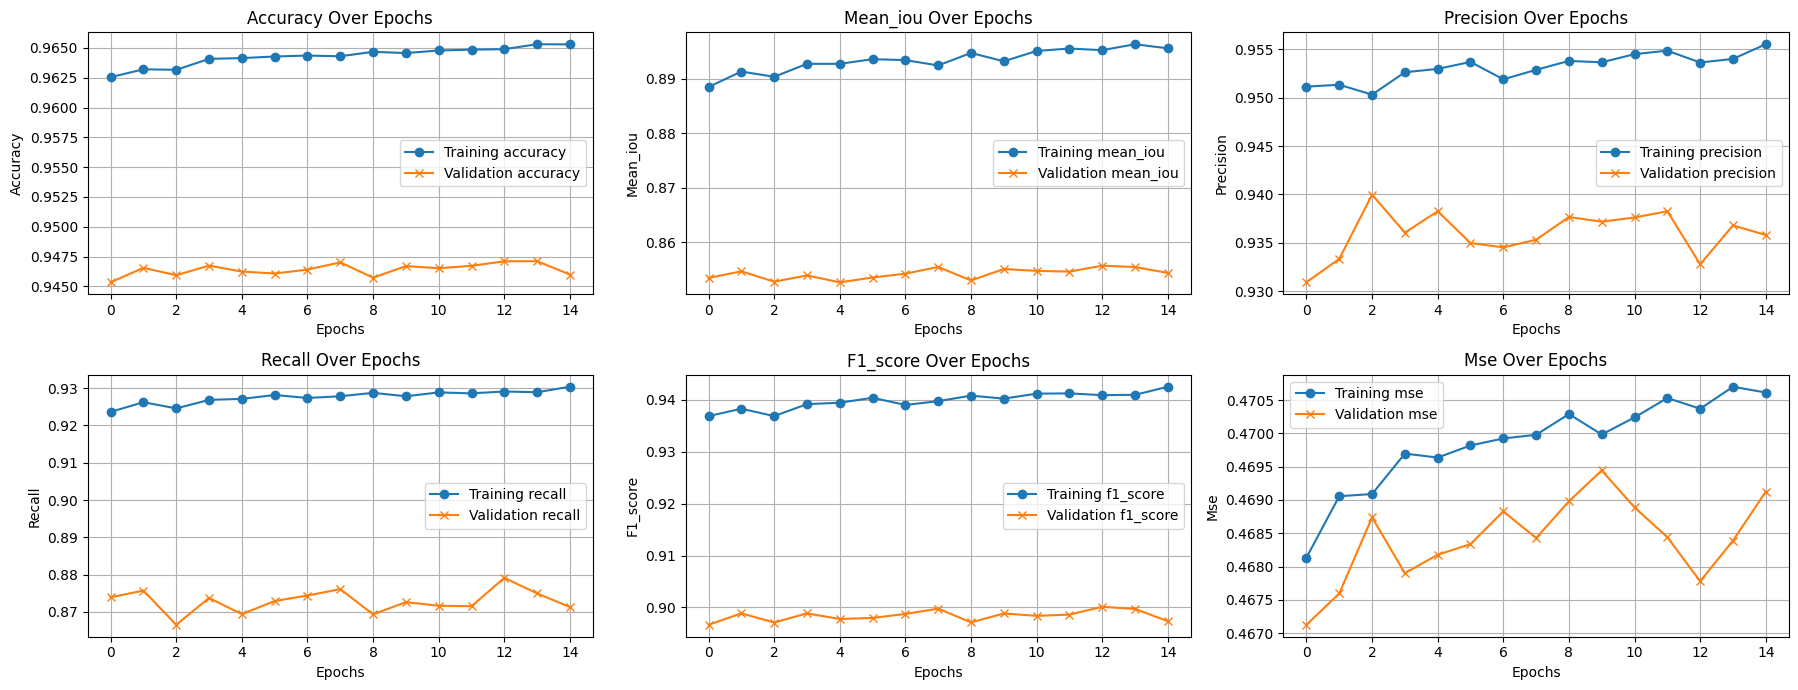

In [55]:
import matplotlib.pyplot as plt

# Extract metrics from the fine-tune history
history = fine_tune_history.history

# Define the metrics to plot
metrics = ["accuracy", "mean_iou", "precision", "recall", "f1_score", "mse"]

# Plot the metrics
plt.figure(figsize=(18, 7))

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plt.plot(history[metric], label=f'Training {metric}', marker='o')
    plt.plot(history[f'val_{metric}'], label=f'Validation {metric}', marker='x')
    plt.title(f'{metric.capitalize()} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [56]:
# Evaluate the model on test dataset
test_results = ensemble_model.evaluate(test_dataset)

print("\nTest results - Loss: {:.4f}, Accuracy: {:.4f}, Mean IOU: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, MSE: {:.4f}".format(*test_results))
# print("\nTest results - Loss: {:.4f}, Accuracy: {:.4f}, Mean IOU: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, MSE: {:.4f}".format(*test_results))


36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step - accuracy: 0.9421 - f1_score: 0.9042 - loss: 0.1787 - mean_iou: 0.8526 - mse: 0.4692 - precision: 0.9181 - recall: 0.8932

Test results - Loss: 0.1921, Accuracy: 0.9399, Mean IOU: 0.8944, Precision: 0.8465, Recall: 0.4680, F1 Score: 0.9144, MSE: 0.8791


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


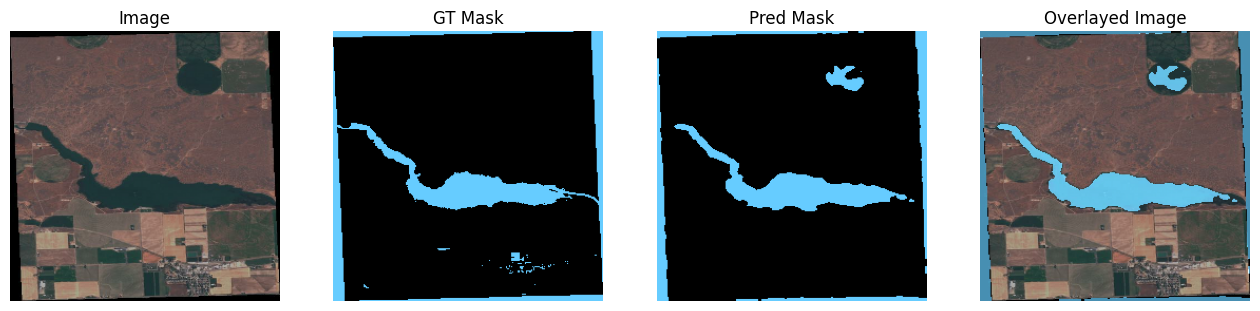

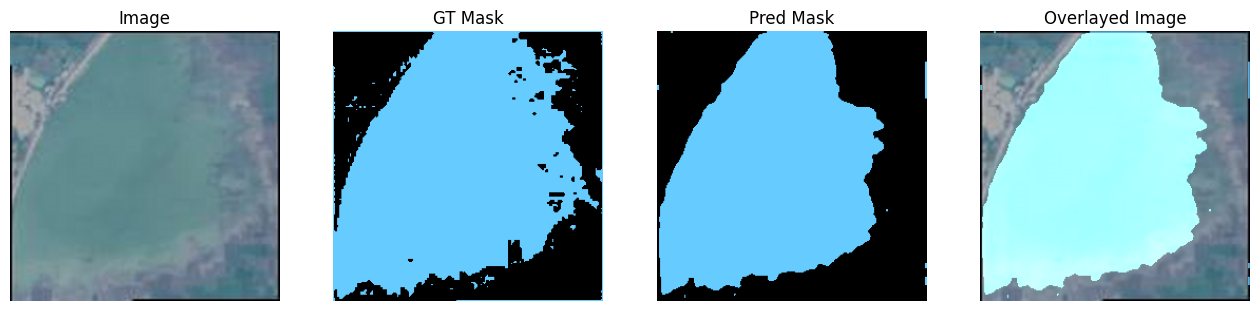

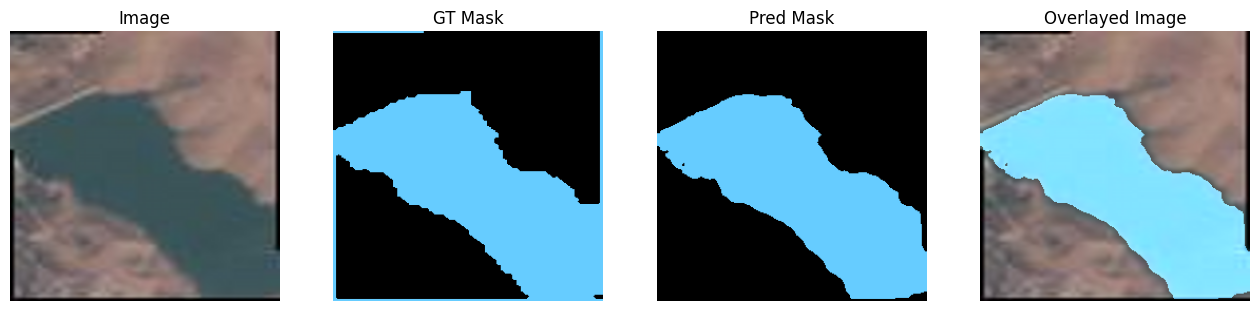

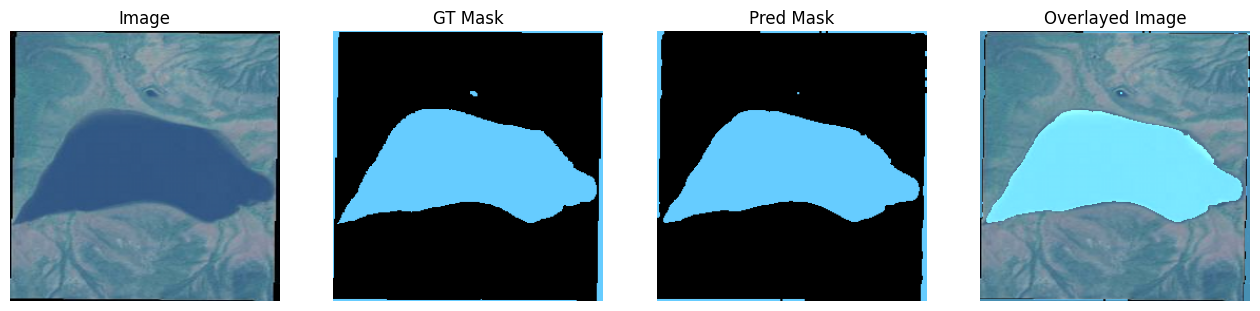

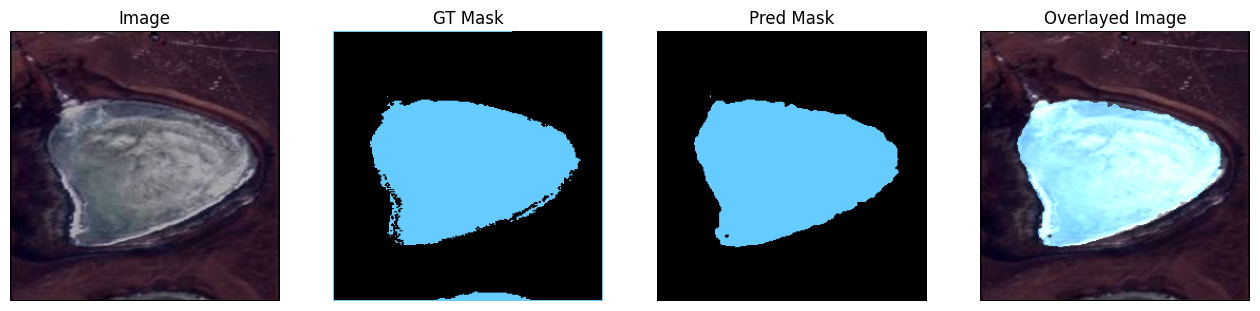

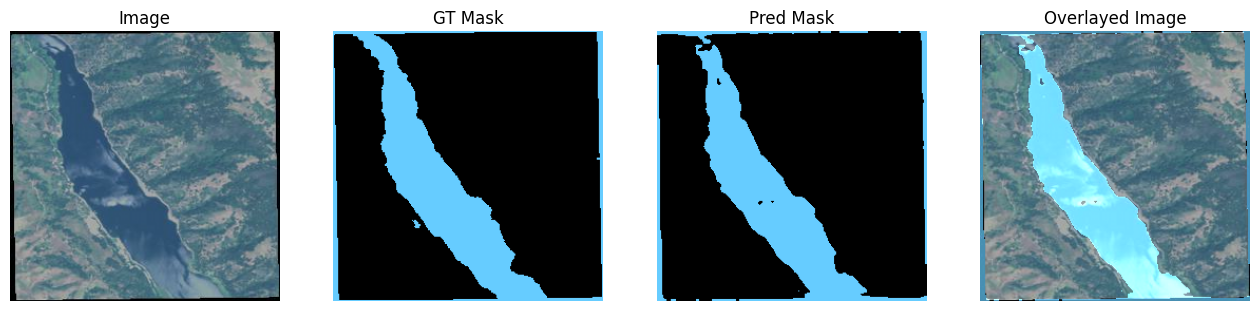

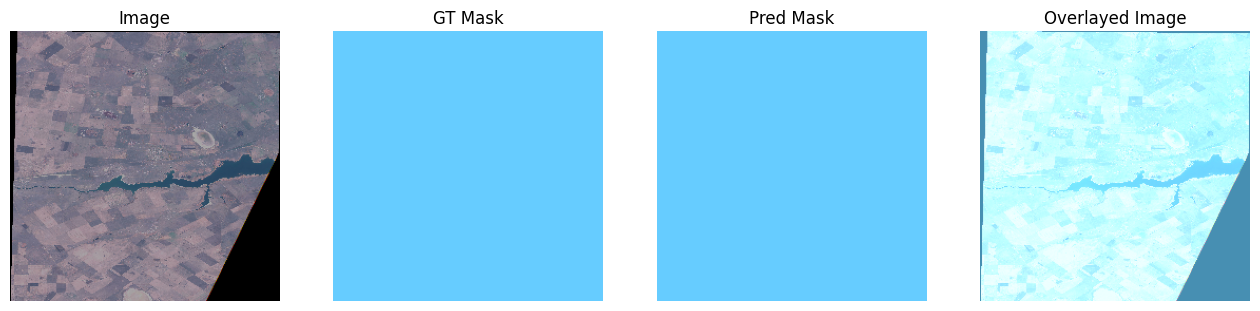

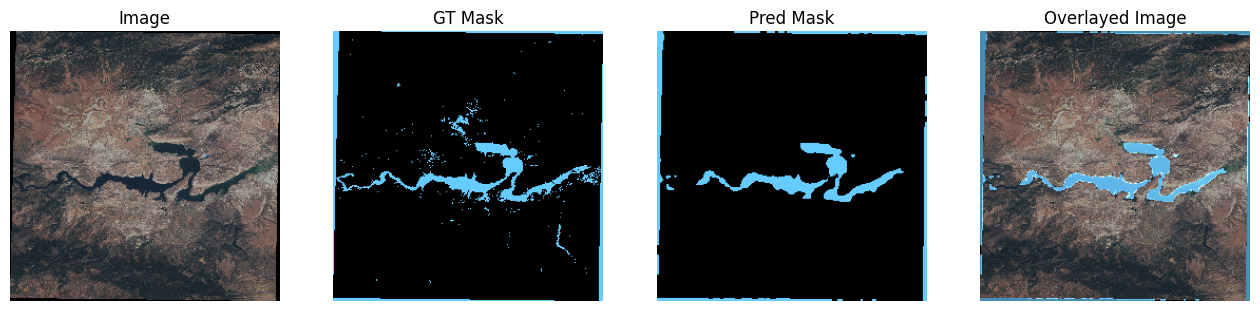

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


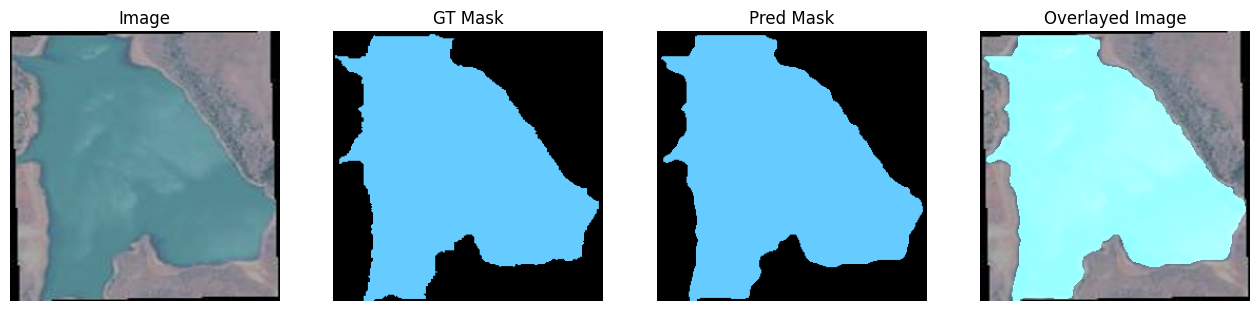

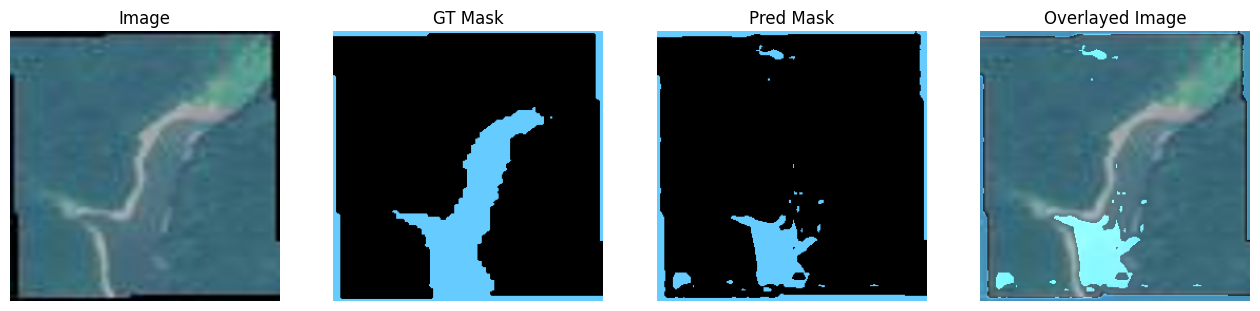

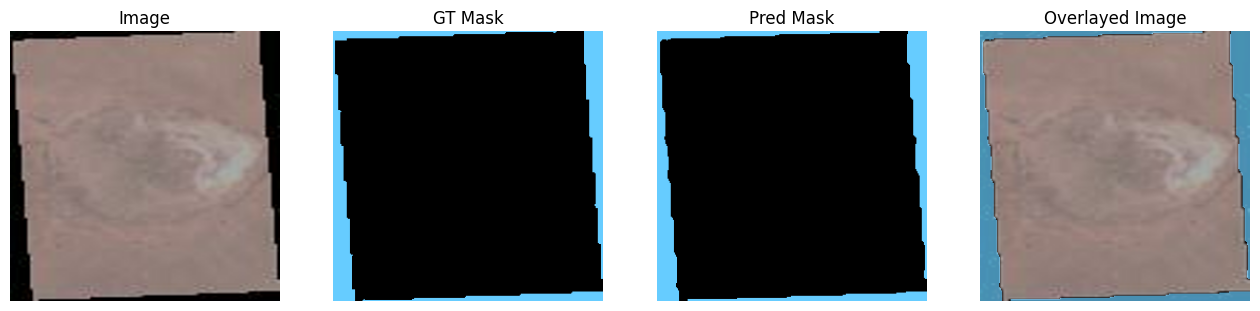

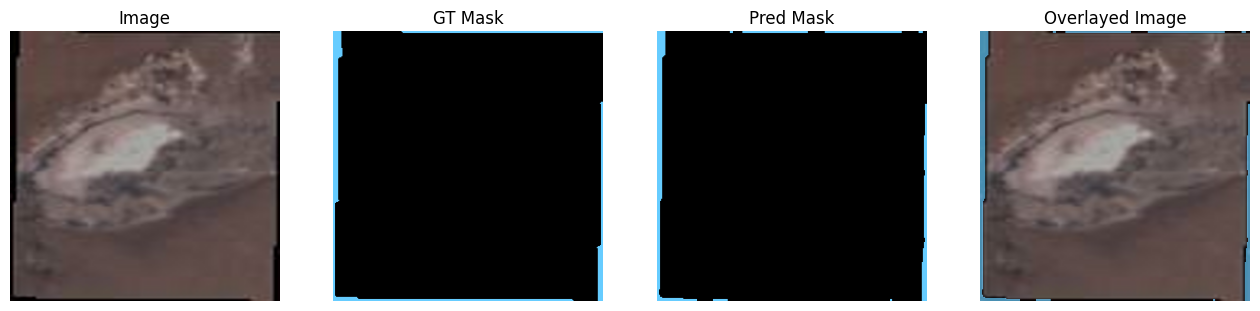

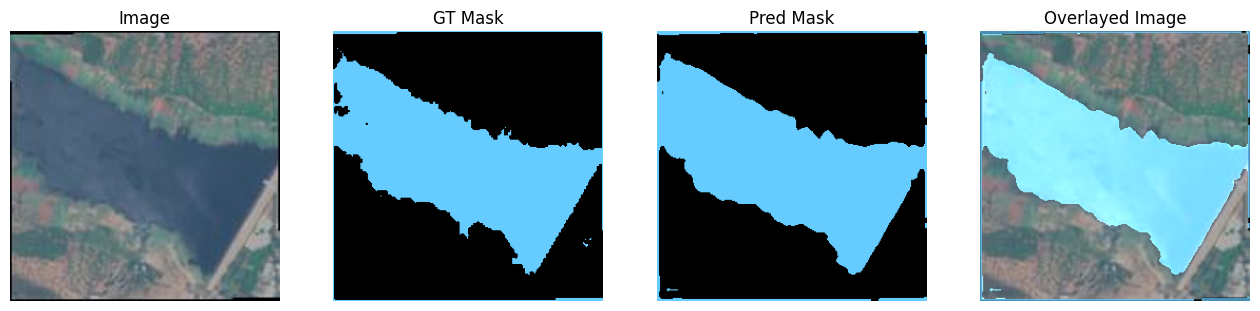

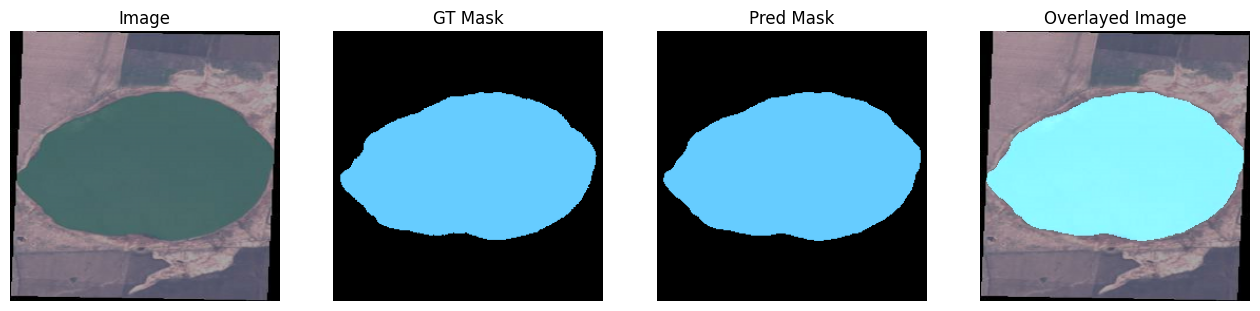

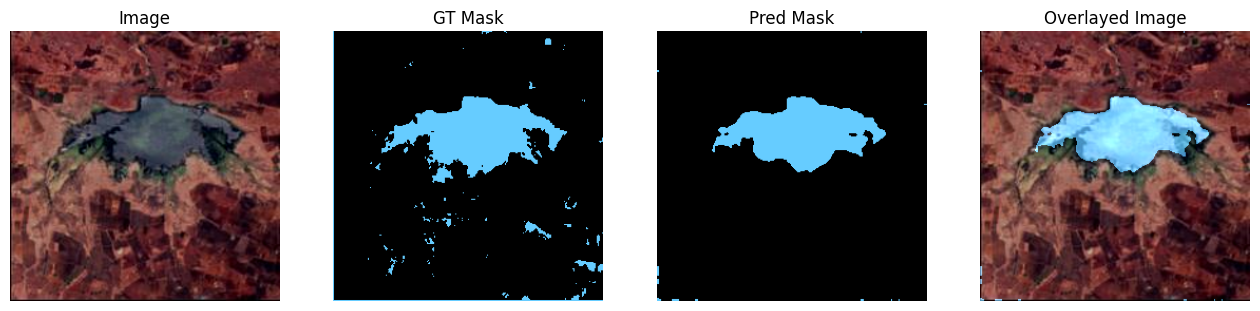

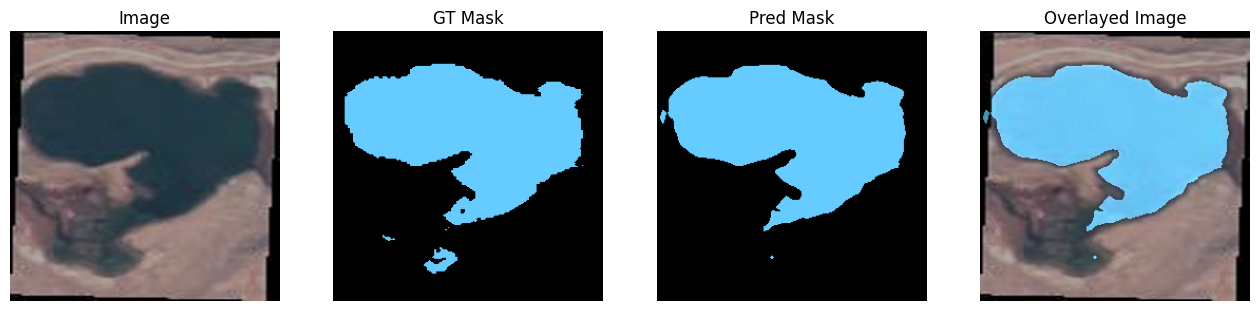

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


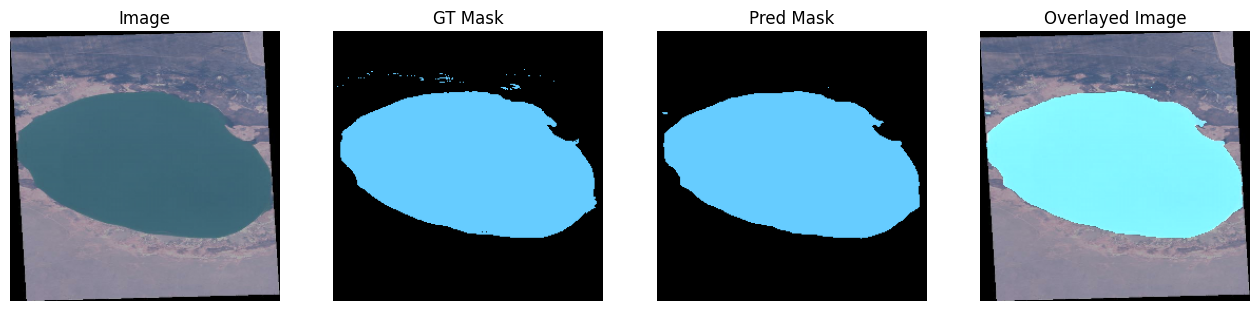

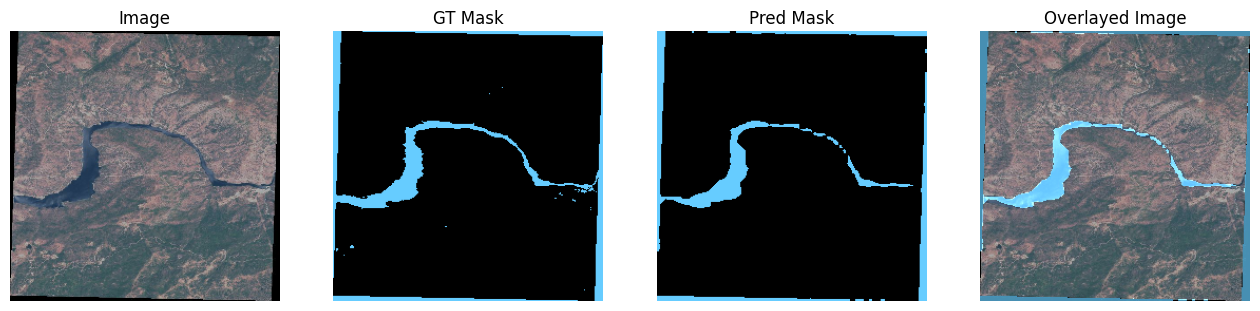

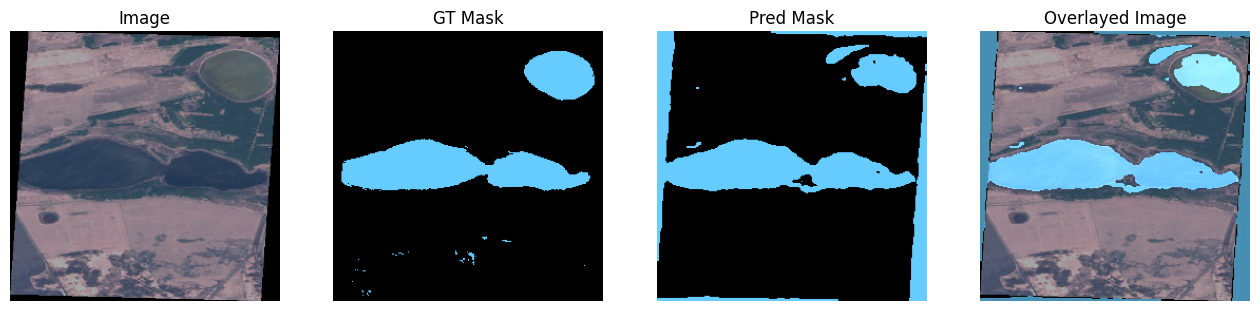

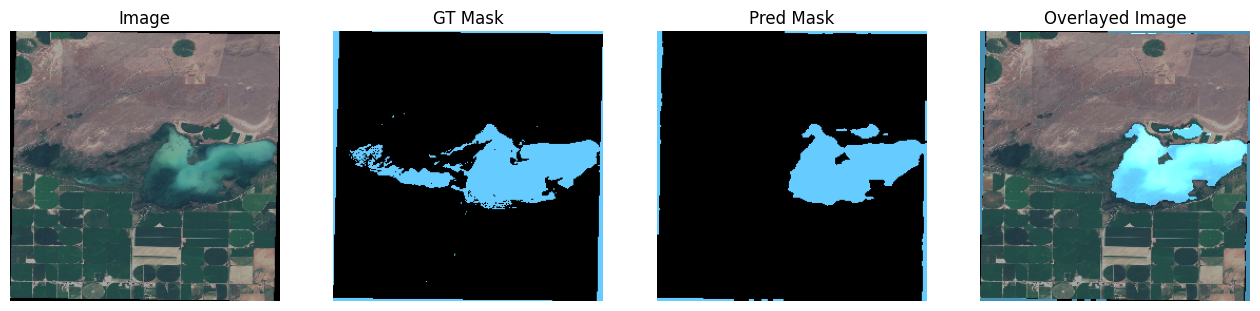

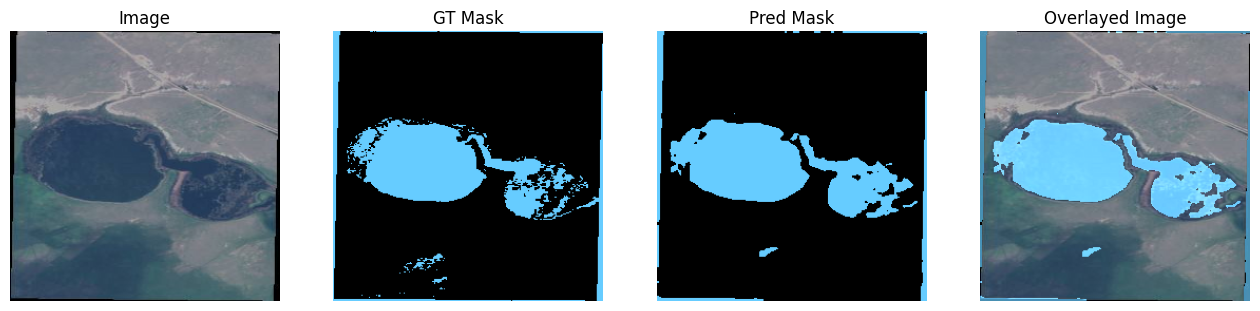

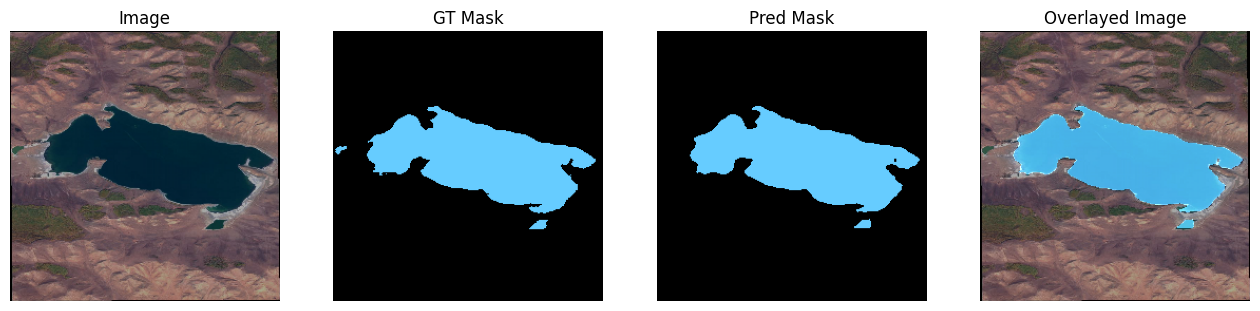

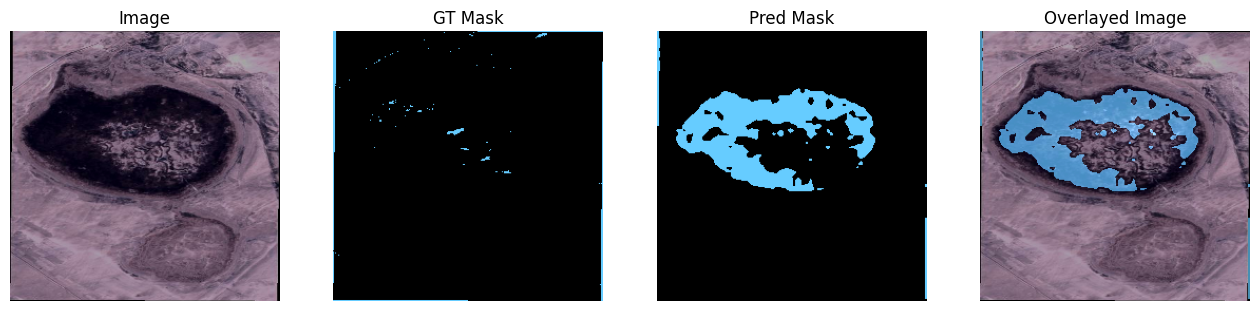

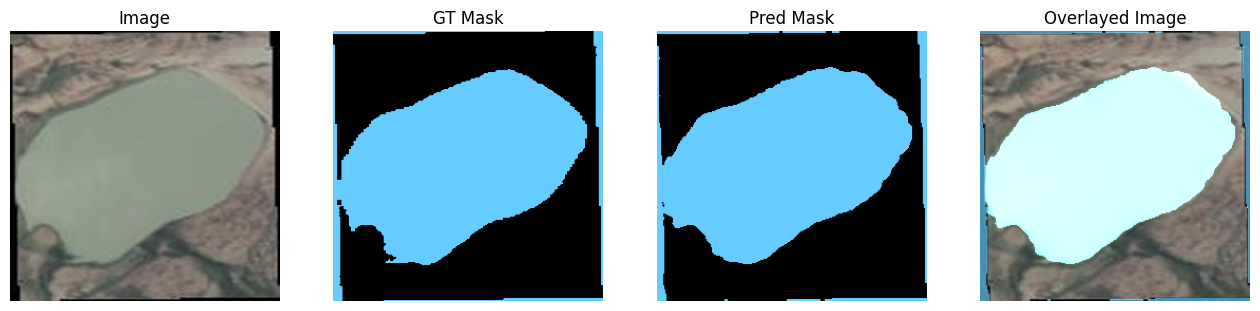

In [57]:
# Visualize predictions on test set
def visualize_predictions(dataset, model, num_images=1):
    for images, masks in dataset.take(num_images):
        predictions = model.predict(images)
        predictions = tf.argmax(predictions, axis=-1)
        for i in range(len(images)):
            gt_mask = tf.squeeze(masks[i], axis=-1).numpy()
            pred_mask = predictions[i].numpy()
            display_image_and_mask([images[i].numpy().astype(np.uint8), gt_mask, pred_mask], title_list=["Image", "GT Mask", "Pred Mask"], figsize=(16, 6), color_mask=True)

# Visualize predictions on test dataset
visualize_predictions(test_dataset, ensemble_model, num_images=3)